In [1]:
from os.path import isfile, isdir
from tqdm import tqdm 
import tarfile
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Extracting data/cifar-10-python.tar.gz to data/


In [3]:
dataset_size = len(dataset)
dataset_size

50000

In [4]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
num_class = len(dataset.classes)
num_class

10

In [6]:
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Label (numeric): 6
Label (textual): frog


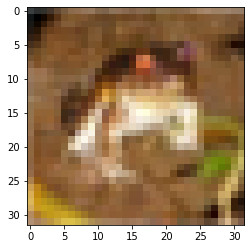

In [9]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [13]:
x = []
for i in range(dataset_size):
    x.append(dataset[i][1])
uimg = torch.tensor(x).unique(sorted=True)
uimg_count = torch.stack([(torch.tensor(x)==i).sum() for i in uimg])
for i in range(len(uimg)):
    print(f'{classes[i]}: {uimg_count[i].item()} count')
    

airplane: 5000 count
automobile: 5000 count
bird: 5000 count
cat: 5000 count
deer: 5000 count
dog: 5000 count
frog: 5000 count
horse: 5000 count
ship: 5000 count
truck: 5000 count


In [16]:
import jovian

<IPython.core.display.Javascript object>

In [17]:
project_name = 'DSI-capstone'

In [18]:
jovian.commit(project=project_name, envioroment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Creating a new project "kayaleo/DSI-capstone"
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ml/kayaleo/dsi-capstone


'https://jovian.ml/kayaleo/dsi-capstone'

# Data prep

In [19]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

In [20]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [21]:
batch_size=128

In [23]:
train_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(dataset, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(dataset, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 3, 32, 32])


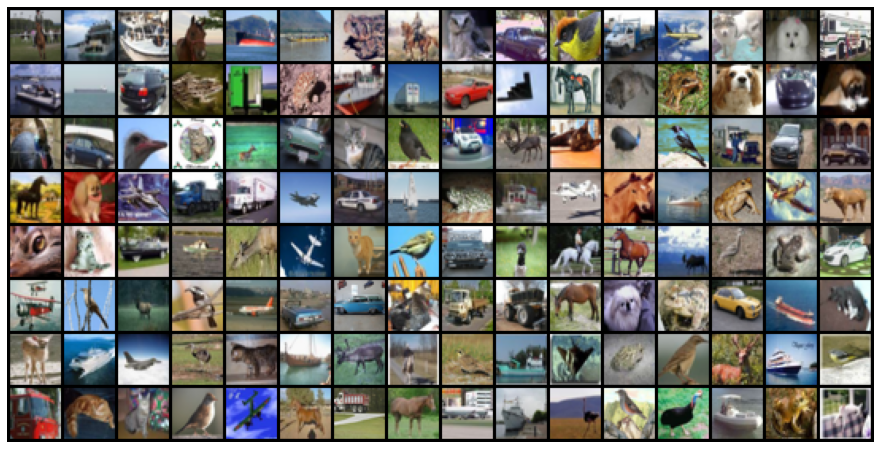

In [24]:
for images, _ in train_loader:
    print("images.shape:", images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# Model

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds ==labels).item() / len(preds))

In [28]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = f.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = f.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [29]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [37]:
torch.cuda.is_available()

False

In [38]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [39]:
device = get_default_device()
device

device(type='cpu')

In [30]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [40]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [41]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [42]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [43]:
input_size = 3*32*32
output_size = 10

In [44]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 1536)
        self.fc2 = nn.Linear(1536, 768)
        self.fc3 = nn.Linear(768, 384)
        self.fc4 = nn.Linear(384, 128)
        self.fc5 = nn.Linear(128, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        out = F.relu(out)
        out = self.fc5(out)
        return out

In [45]:
model = to_device(CIFAR10Model(), device)

In [46]:
history += fit(5, 0.5, model, train_loader, val_loader)

In [47]:
history += fit(5, 0.01, model, train_loader, val_loader)


In [48]:
history += fit(5, 0.001, model, train_loader, val_loader)


In [49]:
history += fit(5, 0.0001, model, train_loader, val_loader)


In [51]:
evaluate(model, test_loader)

NameError: name 'evaluate' is not defined